# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 2105344/11490434 [====>.........................] - ETA: 0s

 8396800/11490434 [====================>.........] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 11:10 - loss: 0.6931

  30/1875 [..............................] - ETA: 3s - loss: 0.5418   

  67/1875 [>.............................] - ETA: 2s - loss: 0.4492

 103/1875 [>.............................] - ETA: 2s - loss: 0.4061

 139/1875 [=>............................] - ETA: 2s - loss: 0.3792

 170/1875 [=>............................] - ETA: 2s - loss: 0.3622

 202/1875 [==>...........................] - ETA: 2s - loss: 0.3481

 233/1875 [==>...........................] - ETA: 2s - loss: 0.3367

 265/1875 [===>..........................] - ETA: 2s - loss: 0.3267

 302/1875 [===>..........................] - ETA: 2s - loss: 0.3167

 337/1875 [====>.........................] - ETA: 2s - loss: 0.3085

 374/1875 [====>.........................] - ETA: 2s - loss: 0.3008

 405/1875 [=====>........................] - ETA: 2s - loss: 0.2951

 440/1875 [======>.......................] - ETA: 2s - loss: 0.2892

 477/1875 [======>.......................] - ETA: 2s - loss: 0.2835

 515/1875 [=======>......................] - ETA: 2s - loss: 0.2782

 553/1875 [=======>......................] - ETA: 1s - loss: 0.2734

 591/1875 [========>.....................] - ETA: 1s - loss: 0.2689

 625/1875 [=========>....................] - ETA: 1s - loss: 0.2652

 655/1875 [=========>....................] - ETA: 1s - loss: 0.2621

 686/1875 [=========>....................] - ETA: 1s - loss: 0.2591

 714/1875 [==========>...................] - ETA: 1s - loss: 0.2565

 745/1875 [==========>...................] - ETA: 1s - loss: 0.2538

 773/1875 [===========>..................] - ETA: 1s - loss: 0.2514

 795/1875 [===========>..................] - ETA: 1s - loss: 0.2496

 828/1875 [============>.................] - ETA: 1s - loss: 0.2471

 852/1875 [============>.................] - ETA: 1s - loss: 0.2453

 880/1875 [=============>................] - ETA: 1s - loss: 0.2433

 911/1875 [=============>................] - ETA: 1s - loss: 0.2412

 939/1875 [==============>...............] - ETA: 1s - loss: 0.2393

 970/1875 [==============>...............] - ETA: 1s - loss: 0.2373

1000/1875 [===============>..............] - ETA: 1s - loss: 0.2355

1030/1875 [===============>..............] - ETA: 1s - loss: 0.2337

1061/1875 [===============>..............] - ETA: 1s - loss: 0.2320

1088/1875 [================>.............] - ETA: 1s - loss: 0.2305

1116/1875 [================>.............] - ETA: 1s - loss: 0.2290

1146/1875 [=================>............] - ETA: 1s - loss: 0.2274

1170/1875 [=================>............] - ETA: 1s - loss: 0.2262

1199/1875 [==================>...........] - ETA: 1s - loss: 0.2248

1229/1875 [==================>...........] - ETA: 1s - loss: 0.2234

1259/1875 [===================>..........] - ETA: 0s - loss: 0.2220

1288/1875 [===================>..........] - ETA: 0s - loss: 0.2207

1318/1875 [====================>.........] - ETA: 0s - loss: 0.2194

1348/1875 [====================>.........] - ETA: 0s - loss: 0.2182

1379/1875 [=====================>........] - ETA: 0s - loss: 0.2169

1409/1875 [=====================>........] - ETA: 0s - loss: 0.2157

1439/1875 [======================>.......] - ETA: 0s - loss: 0.2145

1467/1875 [======================>.......] - ETA: 0s - loss: 0.2135

1495/1875 [======================>.......] - ETA: 0s - loss: 0.2124

1526/1875 [=======================>......] - ETA: 0s - loss: 0.2113

1555/1875 [=======================>......] - ETA: 0s - loss: 0.2103

1583/1875 [========================>.....] - ETA: 0s - loss: 0.2093

1608/1875 [========================>.....] - ETA: 0s - loss: 0.2085

1638/1875 [=========================>....] - ETA: 0s - loss: 0.2075

1664/1875 [=========================>....] - ETA: 0s - loss: 0.2066

1693/1875 [==========================>...] - ETA: 0s - loss: 0.2057

1724/1875 [==========================>...] - ETA: 0s - loss: 0.2048

1753/1875 [===========================>..] - ETA: 0s - loss: 0.2039

1777/1875 [===========================>..] - ETA: 0s - loss: 0.2032

1807/1875 [===========================>..] - ETA: 0s - loss: 0.2023

1839/1875 [============================>.] - ETA: 0s - loss: 0.2014

1870/1875 [============================>.] - ETA: 0s - loss: 0.2005

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2004


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1059

  32/1875 [..............................] - ETA: 2s - loss: 0.1102

  64/1875 [>.............................] - ETA: 2s - loss: 0.1100

  96/1875 [>.............................] - ETA: 2s - loss: 0.1098

 129/1875 [=>............................] - ETA: 2s - loss: 0.1097

 162/1875 [=>............................] - ETA: 2s - loss: 0.1095

 195/1875 [==>...........................] - ETA: 2s - loss: 0.1094

 228/1875 [==>...........................] - ETA: 2s - loss: 0.1092

 261/1875 [===>..........................] - ETA: 2s - loss: 0.1092

 293/1875 [===>..........................] - ETA: 2s - loss: 0.1091

 326/1875 [====>.........................] - ETA: 2s - loss: 0.1090

 359/1875 [====>.........................] - ETA: 2s - loss: 0.1089

 392/1875 [=====>........................] - ETA: 2s - loss: 0.1088

 424/1875 [=====>........................] - ETA: 2s - loss: 0.1087

 457/1875 [======>.......................] - ETA: 2s - loss: 0.1086

 490/1875 [======>.......................] - ETA: 2s - loss: 0.1085

 523/1875 [=======>......................] - ETA: 2s - loss: 0.1084

 556/1875 [=======>......................] - ETA: 2s - loss: 0.1084

 588/1875 [========>.....................] - ETA: 2s - loss: 0.1083

 620/1875 [========>.....................] - ETA: 1s - loss: 0.1082

 652/1875 [=========>....................] - ETA: 1s - loss: 0.1081

 684/1875 [=========>....................] - ETA: 1s - loss: 0.1080

 716/1875 [==========>...................] - ETA: 1s - loss: 0.1080

 748/1875 [==========>...................] - ETA: 1s - loss: 0.1079

 780/1875 [===========>..................] - ETA: 1s - loss: 0.1078

 811/1875 [===========>..................] - ETA: 1s - loss: 0.1078

 843/1875 [============>.................] - ETA: 1s - loss: 0.1077

 875/1875 [=============>................] - ETA: 1s - loss: 0.1076

 908/1875 [=============>................] - ETA: 1s - loss: 0.1075

 940/1875 [==============>...............] - ETA: 1s - loss: 0.1075

 972/1875 [==============>...............] - ETA: 1s - loss: 0.1074

1007/1875 [===============>..............] - ETA: 1s - loss: 0.1073

1039/1875 [===============>..............] - ETA: 1s - loss: 0.1072

1072/1875 [================>.............] - ETA: 1s - loss: 0.1072

1104/1875 [================>.............] - ETA: 1s - loss: 0.1071

1136/1875 [=================>............] - ETA: 1s - loss: 0.1070

1168/1875 [=================>............] - ETA: 1s - loss: 0.1070

1200/1875 [==================>...........] - ETA: 1s - loss: 0.1069

1233/1875 [==================>...........] - ETA: 1s - loss: 0.1068

1266/1875 [===================>..........] - ETA: 0s - loss: 0.1068

1298/1875 [===================>..........] - ETA: 0s - loss: 0.1067

1331/1875 [====================>.........] - ETA: 0s - loss: 0.1066

1364/1875 [====================>.........] - ETA: 0s - loss: 0.1066

1397/1875 [=====================>........] - ETA: 0s - loss: 0.1065

1429/1875 [=====================>........] - ETA: 0s - loss: 0.1064

1461/1875 [======================>.......] - ETA: 0s - loss: 0.1064

1493/1875 [======================>.......] - ETA: 0s - loss: 0.1063

1525/1875 [=======================>......] - ETA: 0s - loss: 0.1063

1557/1875 [=======================>......] - ETA: 0s - loss: 0.1062

1589/1875 [========================>.....] - ETA: 0s - loss: 0.1061

1621/1875 [========================>.....] - ETA: 0s - loss: 0.1061

1653/1875 [=========================>....] - ETA: 0s - loss: 0.1060

1685/1875 [=========================>....] - ETA: 0s - loss: 0.1060

1717/1875 [==========================>...] - ETA: 0s - loss: 0.1059

1749/1875 [==========================>...] - ETA: 0s - loss: 0.1059

1782/1875 [===========================>..] - ETA: 0s - loss: 0.1058

1814/1875 [============================>.] - ETA: 0s - loss: 0.1058

1847/1875 [============================>.] - ETA: 0s - loss: 0.1057

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1057


Epoch 3/5


   1/1875 [..............................] - ETA: 4s - loss: 0.0960

  34/1875 [..............................] - ETA: 2s - loss: 0.0967

  67/1875 [>.............................] - ETA: 2s - loss: 0.0974

  99/1875 [>.............................] - ETA: 2s - loss: 0.0977

 131/1875 [=>............................] - ETA: 2s - loss: 0.0978

 164/1875 [=>............................] - ETA: 2s - loss: 0.0979

 198/1875 [==>...........................] - ETA: 2s - loss: 0.0979

 229/1875 [==>...........................] - ETA: 2s - loss: 0.0979

 261/1875 [===>..........................] - ETA: 2s - loss: 0.0979

 294/1875 [===>..........................] - ETA: 2s - loss: 0.0979

 327/1875 [====>.........................] - ETA: 2s - loss: 0.0979

 359/1875 [====>.........................] - ETA: 2s - loss: 0.0979

 392/1875 [=====>........................] - ETA: 2s - loss: 0.0979

 425/1875 [=====>........................] - ETA: 2s - loss: 0.0979

 457/1875 [======>.......................] - ETA: 2s - loss: 0.0979

 489/1875 [======>.......................] - ETA: 2s - loss: 0.0979

 521/1875 [=======>......................] - ETA: 2s - loss: 0.0979

 545/1875 [=======>......................] - ETA: 2s - loss: 0.0979

 575/1875 [========>.....................] - ETA: 2s - loss: 0.0979

 603/1875 [========>.....................] - ETA: 2s - loss: 0.0979

 634/1875 [=========>....................] - ETA: 2s - loss: 0.0979

 665/1875 [=========>....................] - ETA: 1s - loss: 0.0979

 696/1875 [==========>...................] - ETA: 1s - loss: 0.0979

 729/1875 [==========>...................] - ETA: 1s - loss: 0.0979

 756/1875 [===========>..................] - ETA: 1s - loss: 0.0978

 789/1875 [===========>..................] - ETA: 1s - loss: 0.0978

 820/1875 [============>.................] - ETA: 1s - loss: 0.0978

 849/1875 [============>.................] - ETA: 1s - loss: 0.0978

 877/1875 [=============>................] - ETA: 1s - loss: 0.0978

 905/1875 [=============>................] - ETA: 1s - loss: 0.0978

 937/1875 [=============>................] - ETA: 1s - loss: 0.0978

 972/1875 [==============>...............] - ETA: 1s - loss: 0.0978

1003/1875 [===============>..............] - ETA: 1s - loss: 0.0978

1035/1875 [===============>..............] - ETA: 1s - loss: 0.0978

1060/1875 [===============>..............] - ETA: 1s - loss: 0.0978

1089/1875 [================>.............] - ETA: 1s - loss: 0.0978

1115/1875 [================>.............] - ETA: 1s - loss: 0.0978

1149/1875 [=================>............] - ETA: 1s - loss: 0.0978

1180/1875 [=================>............] - ETA: 1s - loss: 0.0978

1211/1875 [==================>...........] - ETA: 1s - loss: 0.0978

1238/1875 [==================>...........] - ETA: 1s - loss: 0.0978

1256/1875 [===================>..........] - ETA: 1s - loss: 0.0978

1284/1875 [===================>..........] - ETA: 0s - loss: 0.0978

1313/1875 [====================>.........] - ETA: 0s - loss: 0.0978

1345/1875 [====================>.........] - ETA: 0s - loss: 0.0977

1373/1875 [====================>.........] - ETA: 0s - loss: 0.0977

1403/1875 [=====================>........] - ETA: 0s - loss: 0.0977

1429/1875 [=====================>........] - ETA: 0s - loss: 0.0977

1457/1875 [======================>.......] - ETA: 0s - loss: 0.0977

1478/1875 [======================>.......] - ETA: 0s - loss: 0.0977

1509/1875 [=======================>......] - ETA: 0s - loss: 0.0977

1539/1875 [=======================>......] - ETA: 0s - loss: 0.0977

1560/1875 [=======================>......] - ETA: 0s - loss: 0.0977

1592/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1626/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1660/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1695/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1730/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1764/1875 [===========================>..] - ETA: 0s - loss: 0.0977

1798/1875 [===========================>..] - ETA: 0s - loss: 0.0977

1831/1875 [============================>.] - ETA: 0s - loss: 0.0977

1864/1875 [============================>.] - ETA: 0s - loss: 0.0977

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0977


Epoch 4/5
   1/1875 [..............................] - ETA: 2s - loss: 0.1042

  35/1875 [..............................] - ETA: 2s - loss: 0.0997

  69/1875 [>.............................] - ETA: 2s - loss: 0.0985

 103/1875 [>.............................] - ETA: 2s - loss: 0.0980

 136/1875 [=>............................] - ETA: 2s - loss: 0.0977

 170/1875 [=>............................] - ETA: 2s - loss: 0.0975

 204/1875 [==>...........................] - ETA: 2s - loss: 0.0974

 238/1875 [==>...........................] - ETA: 2s - loss: 0.0973

 272/1875 [===>..........................] - ETA: 2s - loss: 0.0972

 307/1875 [===>..........................] - ETA: 2s - loss: 0.0971

 328/1875 [====>.........................] - ETA: 2s - loss: 0.0971

 357/1875 [====>.........................] - ETA: 2s - loss: 0.0970

 391/1875 [=====>........................] - ETA: 2s - loss: 0.0970

 423/1875 [=====>........................] - ETA: 2s - loss: 0.0969

 451/1875 [======>.......................] - ETA: 2s - loss: 0.0969

 484/1875 [======>.......................] - ETA: 2s - loss: 0.0969

 514/1875 [=======>......................] - ETA: 2s - loss: 0.0968

 544/1875 [=======>......................] - ETA: 2s - loss: 0.0968

 572/1875 [========>.....................] - ETA: 2s - loss: 0.0968

 606/1875 [========>.....................] - ETA: 2s - loss: 0.0967

 633/1875 [=========>....................] - ETA: 1s - loss: 0.0967

 665/1875 [=========>....................] - ETA: 1s - loss: 0.0967

 696/1875 [==========>...................] - ETA: 1s - loss: 0.0967

 720/1875 [==========>...................] - ETA: 1s - loss: 0.0967

 750/1875 [===========>..................] - ETA: 1s - loss: 0.0966

 783/1875 [===========>..................] - ETA: 1s - loss: 0.0966

 815/1875 [============>.................] - ETA: 1s - loss: 0.0966

 846/1875 [============>.................] - ETA: 1s - loss: 0.0966

 879/1875 [=============>................] - ETA: 1s - loss: 0.0966

 911/1875 [=============>................] - ETA: 1s - loss: 0.0966

 936/1875 [=============>................] - ETA: 1s - loss: 0.0966

 967/1875 [==============>...............] - ETA: 1s - loss: 0.0966

 994/1875 [==============>...............] - ETA: 1s - loss: 0.0965

1024/1875 [===============>..............] - ETA: 1s - loss: 0.0965

1058/1875 [===============>..............] - ETA: 1s - loss: 0.0965

1088/1875 [================>.............] - ETA: 1s - loss: 0.0965

1120/1875 [================>.............] - ETA: 1s - loss: 0.0965

1151/1875 [=================>............] - ETA: 1s - loss: 0.0965

1183/1875 [=================>............] - ETA: 1s - loss: 0.0965

1214/1875 [==================>...........] - ETA: 1s - loss: 0.0964

1246/1875 [==================>...........] - ETA: 1s - loss: 0.0964

1276/1875 [===================>..........] - ETA: 0s - loss: 0.0964

1309/1875 [===================>..........] - ETA: 0s - loss: 0.0964

1345/1875 [====================>.........] - ETA: 0s - loss: 0.0964

1381/1875 [=====================>........] - ETA: 0s - loss: 0.0964

1417/1875 [=====================>........] - ETA: 0s - loss: 0.0964

1453/1875 [======================>.......] - ETA: 0s - loss: 0.0964

1488/1875 [======================>.......] - ETA: 0s - loss: 0.0963

1523/1875 [=======================>......] - ETA: 0s - loss: 0.0963

1559/1875 [=======================>......] - ETA: 0s - loss: 0.0963

1594/1875 [========================>.....] - ETA: 0s - loss: 0.0963

1629/1875 [=========================>....] - ETA: 0s - loss: 0.0963

1662/1875 [=========================>....] - ETA: 0s - loss: 0.0963

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0963

1731/1875 [==========================>...] - ETA: 0s - loss: 0.0963

1764/1875 [===========================>..] - ETA: 0s - loss: 0.0963

1798/1875 [===========================>..] - ETA: 0s - loss: 0.0963

1831/1875 [============================>.] - ETA: 0s - loss: 0.0963

1865/1875 [============================>.] - ETA: 0s - loss: 0.0963

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0963


Epoch 5/5
   1/1875 [..............................] - ETA: 5s - loss: 0.1038

  36/1875 [..............................] - ETA: 2s - loss: 0.0958

  68/1875 [>.............................] - ETA: 2s - loss: 0.0952

 102/1875 [>.............................] - ETA: 2s - loss: 0.0951

 136/1875 [=>............................] - ETA: 2s - loss: 0.0951

 171/1875 [=>............................] - ETA: 2s - loss: 0.0950

 206/1875 [==>...........................] - ETA: 2s - loss: 0.0950

 240/1875 [==>...........................] - ETA: 2s - loss: 0.0950

 275/1875 [===>..........................] - ETA: 2s - loss: 0.0950

 310/1875 [===>..........................] - ETA: 2s - loss: 0.0950

 345/1875 [====>.........................] - ETA: 2s - loss: 0.0951

 379/1875 [=====>........................] - ETA: 2s - loss: 0.0951

 412/1875 [=====>........................] - ETA: 2s - loss: 0.0951

 446/1875 [======>.......................] - ETA: 2s - loss: 0.0951

 479/1875 [======>.......................] - ETA: 2s - loss: 0.0951

 513/1875 [=======>......................] - ETA: 2s - loss: 0.0951

 547/1875 [=======>......................] - ETA: 1s - loss: 0.0951

 583/1875 [========>.....................] - ETA: 1s - loss: 0.0951

 617/1875 [========>.....................] - ETA: 1s - loss: 0.0951

 652/1875 [=========>....................] - ETA: 1s - loss: 0.0952

 686/1875 [=========>....................] - ETA: 1s - loss: 0.0952

 722/1875 [==========>...................] - ETA: 1s - loss: 0.0952

 758/1875 [===========>..................] - ETA: 1s - loss: 0.0952

 794/1875 [===========>..................] - ETA: 1s - loss: 0.0952

 829/1875 [============>.................] - ETA: 1s - loss: 0.0952

 864/1875 [============>.................] - ETA: 1s - loss: 0.0952

 898/1875 [=============>................] - ETA: 1s - loss: 0.0952

 932/1875 [=============>................] - ETA: 1s - loss: 0.0952

 966/1875 [==============>...............] - ETA: 1s - loss: 0.0952

1001/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1036/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1071/1875 [================>.............] - ETA: 1s - loss: 0.0952

1106/1875 [================>.............] - ETA: 1s - loss: 0.0952

1140/1875 [=================>............] - ETA: 1s - loss: 0.0952

1175/1875 [=================>............] - ETA: 1s - loss: 0.0952

1211/1875 [==================>...........] - ETA: 0s - loss: 0.0952

1246/1875 [==================>...........] - ETA: 0s - loss: 0.0952

1282/1875 [===================>..........] - ETA: 0s - loss: 0.0952

1319/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1354/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1391/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1428/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1465/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1500/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1534/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1570/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1607/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1644/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1681/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1718/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1755/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1828/1875 [============================>.] - ETA: 0s - loss: 0.0952

1864/1875 [============================>.] - ETA: 0s - loss: 0.0952

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0952


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

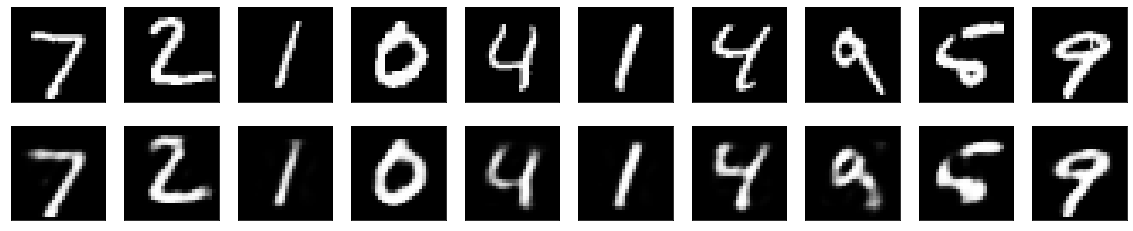

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
